In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from typing import List
import math

In [4]:
import numpy as np
import sympy as sp
from typing import List
import math

class PolinomioHermite:
    def __init__(self, D: list[tuple[float, ...]]):
        """Inicializa o Polinômio Interpolador de Hermite.
        
        Args:
            D: Lista de tuplas estruturada como (x,f(x),f'(x),...,f^k(x)).

        Raises:
            ValueError: Se os dados não existem ou se não houver x e f(x) para todos os
                        pontos informados.
        """
        if not D or not all(len(d) > 1 for d in D):
            raise ValueError
            
        self.data = D
        self.condicoes = sum(len(d) - 1 for d in D)
        self.grau = self.condicoes - 1
        
        self.x = np.zeros(self.condicoes)
        self.y = np.zeros(self.condicoes) 
        self.derivadas = {}
        indice = 0
        for tupla in D:
            x = tupla[0]
            derivadas = len(tupla) - 1
            for i in range(derivadas):
                self.x[indice + i] = x #x
                self.y[indice + i] = tupla[1] #f(x)
                self.derivadas[(x, i)] = tupla[1 + i] #derivadas
            indice += derivadas
        self._coeficientes = self.newton()
        
    def newton(self) -> np.ndarray:
        """Calcula os coeficientes do polinômio de Hermite pelo método de Newton de
           diferenças divididas."""
        
        # tabela de diferenças divididas
        d = np.zeros((self.condicoes, self.condicoes))
        d[:, 0] = self.y 
        
        for i in range(1, self.condicoes):
            for j in range(self.condicoes - i):
                if self.x[j] != self.x[j+i]:
                    # Regra de Newton
                    d[j, i] = (d[j+1, i-1] - d[j, i-1]) / (self.x[j+i] - self.x[j])
                else:
                    # f^(i)(x)/i!
                    x = self.x[j]
                    derivada = self.derivadas.get((x, i), 0.0) 
                    d[j, i] = derivada / math.factorial(i)
        return d[0]
    
    @property
    def coeficientes(self) -> list[float]:
        return self._todos_coeficientes()
    
    @property
    def polinomio(self) -> str:
        return str(self._forma_padrao_simbolica())

    def __repr__(self) -> list[float]:
        return self._todos_coeficientes()

    def __str__(self) -> str:
        """Representa em string o polinômio interpolador na forma de Newton."""
        return str(self._forma_padrao_simbolica())

    def avaliar(self, x: float|int) -> float:
        """Avalia o polinômio interpolador para o valor x.
        
        Args:
            x: Valor a ser interpolado.

        Returns:
            float: Resultado de x no polinômio interpolador.

        Raises:
            ValueError: Se x não é do tipo numérico 
        """
        if len(self._coeficientes) == 0:
            return 0
        polinomio = self._coeficientes[0] # c_0
        for i in range(1, self.condicoes):
            termo = self._coeficientes[i] # c_i
            for j in range(i):
                termo *=(x-self.x[j])
            polinomio += termo
        return polinomio

    def _forma_padrao_simbolica(self) -> sp.Expr:
            """
            Calcula e retorna o polinômio na forma padrão (expandida)
            usando a biblioteca SymPy.
            """
            if len(self._coeficientes) == 0:
                return sp.Integer(0)

            x = sp.Symbol('x')
            poly = sp.Float(self._coeficientes[0])
            prod_term = 1
            
            for i in range(1, self.condicoes):
                # (x - z0) * (x - z1) * ... * (x - z_{i-1})
                prod_term *= (x - self.x[i - 1])
                # Adiciona c_i * produto
                poly += sp.Float(self._coeficientes[i]) * prod_term

            return sp.expand(poly)

    def _todos_coeficientes(self) -> list[float]:
        expressao = self._forma_padrao_simbolica()

        if expressao == sp.Integer(0) and self.grau >= 0:
            return [0.0] * (self.grau + 1)
        
        x = sp.Symbol('x')
        polinomio_obj = expressao.as_poly()

        coeficientes = polinomio_obj.all_coeffs()

        resultado = [float(coeficiente) for coeficiente in coeficientes]
        return resultado
        
    def __call__(self, x: float|int|list[float|int]|np.ndarray) -> float|list[float]:
        """Permite que o polinômio atue como uma função matemática com entrada x.
        
        Args:
            x: Valor(es) a ser(em) interpolado(s).

        Returns:
            Resultado de x no polinômio interpolador.

        Raises:
            ValueError: Se x não é do tipo numérico.
        """
        if isinstance(x, (float, int, np.float64, np.float32, np.int64, np.int32)):
            return self.avaliar(float(x)) 
        elif isinstance(x, (list, np.ndarray)):
            resultados = [self.avaliar(float(i)) for i in x]
            return resultados
        raise ValueError

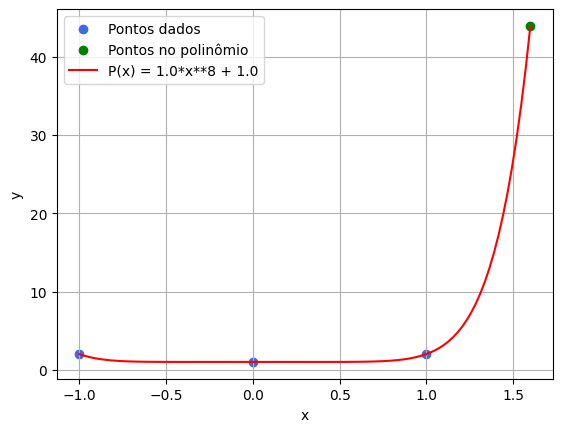

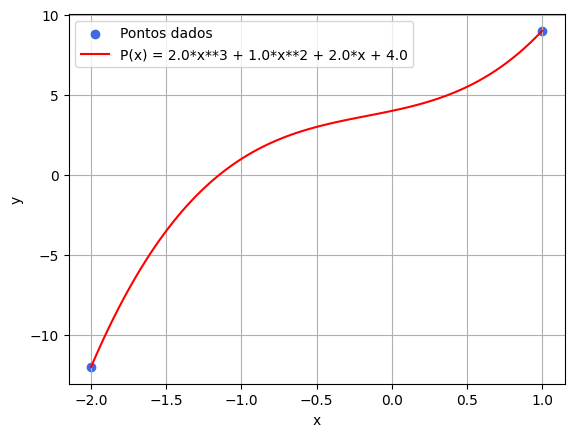

In [ ]:
def plot_polinomioHermite(D, p=None):
    """Plota polinômio interpolador e pontos dados.

        O método plota o polinômio interpolador calculado pela classe PolinomioInterpolador
        e os pontos dos dados originais e, opcionalmente, novos pontos calculados pelo
        polinômio.
        
        Args:
            x: Coordenadas x dos pontos de interpolação. Pode ser uma lista ou array numpy.
            y: Coordenadas y dos pontos de interpolação. Pode ser uma lista ou array numpy.
            p: Coordenadas x dos novos pontos a serem plotados pelo polinômio interpolador.
    """
    polinomio = PolinomioHermite(D)
    dados = np.array([[x[0], x[1]] for x in D])

    # Plotar pontos originais
    plt.scatter(dados[:,0], dados[:,1], color='royalblue', label='Pontos dados')
    Min = min(dados[:,0])
    Max = max(dados[:,0])
    if p:
        plt.scatter(p, polinomio(p), color='green', label='Pontos no polinômio')
        if isinstance(p,(list,np.ndarray)):
            if min(p)<Min:
                Min=min(p)
            if max(p)>Max:
                Max=max(p)
        else:
            if p<Min:
                Min=p
            if p>Max:
                Max=p
    num_pts = 100
    X = np.linspace(Min, Max, num_pts)
    Y = np.polyval(polinomio.coeficientes, X)
    plt.plot(X, Y, '-r', label=f'P(x) = {polinomio}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplos:
X1 = [(-1,2,-8,56),(0,1,0,0),(1,2,8,56)]
plot_polinomioHermite(X1, 1.6)
X2 = [(-2,-12,22),(1,9,10)]
plot_polinomioHermite(X2)